In [ ]:
# Install specific libraries
! brew install cmake
! pip install --upgrade setuptools wheel
! pip install transformers
! pip install pycaret
! pip install lime

In [1]:
import numpy as np
import pandas as pd
# import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast, pipeline, DistilBertTokenizerFast, TFDistilBertModel, DistilBertConfig
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
import torch.nn.functional as F
from lime.lime_text import LimeTextExplainer
# specify GPU
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

/Users/jiangzongzhe/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/Users/jiangzongzhe/anaconda3/lib/python3.11/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


No GPU available, using the CPU instead.


In [ ]:
# Mount Google Drive - applicable, if working on Google Drive
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google.colab'

In [2]:
# Set Working Directory - if working on Google Drive
%cd "/content/drive/MyDrive/Colab_Notebooks/"

# # Set Working Directory - if working on Local Machine
# import os
# os.chdir('/Users//replace_me')

[Errno 2] No such file or directory: '/content/drive/MyDrive/Colab_Notebooks/'
/Users/jiangzongzhe


In [ ]:
!ls

Applications    Downloads       Music           PycharmProjects
Desktop         Library         Pictures        anaconda3
Documents       Movies          Public          myenv


In [3]:
# Load Dataset
import csv
data = pd.read_csv("Downloads/train.tsv", header = 0, delimiter="\t", quoting=csv.QUOTE_NONE)
data_test = pd.read_csv("Downloads/test.tsv", header = 1, delimiter="\t", quoting=csv.QUOTE_NONE)

# See how the data looks like
print(data.shape)
data.head()

print(data_test.shape)
data_test.head()

(1102, 4)
(2000, 3)


,nlp_title,nlp_text,nlp_comments
0,so a***ton of cp and multiple illegal weapons ...,NaN,the man worked as a director on some bbc and c...
1,demo of the average brits understanding of 80k...,NaN,lots of people don't seem to understand that t...
2,please do adobe next.,NaN,if you can join something with a couple of cli...
3,private companies that spend billions on lobby...,NaN,yup california had a free online tax filing sy...
4,he is dead. his name was len sassaman,peope say he might sell his 1m coins one day b...,he might sell his 1m coins one day but dont y...


In [4]:
# Target column is made of string values Real/Fake, let's change it to numbers 0/1 (Fake=1)
data = data.fillna("NIL")
data['label'] = pd.get_dummies(data.nlp_class)['real'].astype(int)

# data_test = data_test.fillna("NIL")
# data_test['label'] = pd.get_dummies(data_test.nlp_title)['fake']

In [5]:
print(data.shape)
data.head()

(1102, 5)


,nlp_title,nlp_text,nlp_comments,nlp_class,label
0,attend a gp like that and see if you can sneak...,NIL,i dont understand your halloween costume eithe...,real,1
1,misleading title.,NIL,blaming the president for a software deficit. ...,fake,0
2,"nah, thats still vegan",NIL,it just means it made in the same factory as o...,fake,0
3,confusing article. it starts out talk about do...,NIL,this entire article is basically the ceo sayin...,fake,0
4,ag barr just resigned as well.,NIL,i hope that biden does well for the same reaso...,real,1


([<matplotlib.patches.Wedge at 0x2902fe910>,
 [Text(-1.1607184127205457, -0.3045205516406029, 'Fake'),
  Text(1.1607184127205457, 0.3045205516406027, 'Real')],
 [Text(-0.6770857407536517, -0.1776369884570183, '58.2%'),
  Text(0.6770857407536517, 0.17763698845701825, '41.8%')])

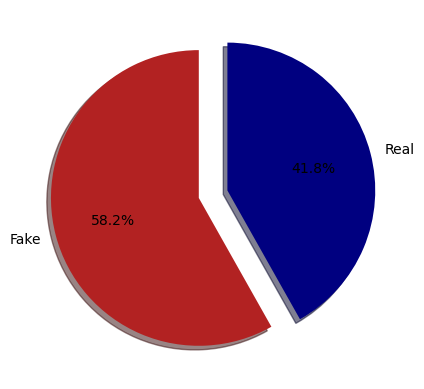

In [6]:
# Checking if our data is well balanced
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','Real'],autopct='%1.1f%%')

In [7]:
# Train-Validation set split into 80:20 ratio

# Train-Validation split
train_text_1, val_text_1, train_labels_1, val_labels_1 = train_test_split(data['nlp_title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.2,
                                                                    stratify=data['label'])

train_text_2, val_text_2, train_labels_2, val_labels_2 = train_test_split(data['nlp_comments'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.2,
                                                                    stratify=data['label'])

train_text_3, val_text_3, train_labels_3, val_labels_3 = train_test_split(data['nlp_text'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.2,
                                                                    stratify=data['label'])



train_text = pd.concat([train_text_1, train_text_2, train_text_3], ignore_index=True)
val_text = pd.concat([val_text_1, val_text_2, val_text_3], ignore_index=True)
train_labels = pd.concat([train_labels_1, train_labels_2, train_labels_3], ignore_index=True)
val_labels = pd.concat([val_labels_1, val_labels_2, val_labels_3], ignore_index=True)

test_text_1 = data['nlp_title']
test_text_2 = data['nlp_text']
test_text_3 = data['nlp_comments']

test_labels_1 = data['label']




print(len(val_labels))
print(len(test_labels_1))



# Validation-Test split
# val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
#                                                                 random_state=2018,
#                                                                 test_size=0.5,
#                                                                 stratify=temp_labels)

663
1102


In [8]:
# Load BERT model and tokenizer via HuggingFace Transformers https://huggingface.co/models
bert = AutoModel.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [9]:
# BERT Tokenizer Functionality
# 1. Start token is 101, End token is 102
# 2. Certain words are break up into sub words e.g. subword is broken into sub ##word
samples = ["snowboard snowball snowman.",
           "subclass subrent."]

for sample in samples:
  tokens = tokenizer.tokenize(sample)
  print("tokens:      ", tokens)
  tokenized_sample = tokenizer.batch_encode_plus(
      [sample],
      max_length = 10,
      padding=True,
      truncation=True
  )
  print(tokenized_sample)

# Ref: https://huggingface.co/docs/transformers/preprocessing

tokens:       ['snow', '##board', 'snow', '##ball', 'snow', '##man', '.']
{'input_ids': [[101, 4586, 6277, 4586, 7384, 4586, 2386, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1]]}
tokens:       ['sub', '##class', 'sub', '##rent', '.']
{'input_ids': [[101, 4942, 26266, 4942, 22787, 1012, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1]]}


Text(0, 0.5, 'Number of texts')

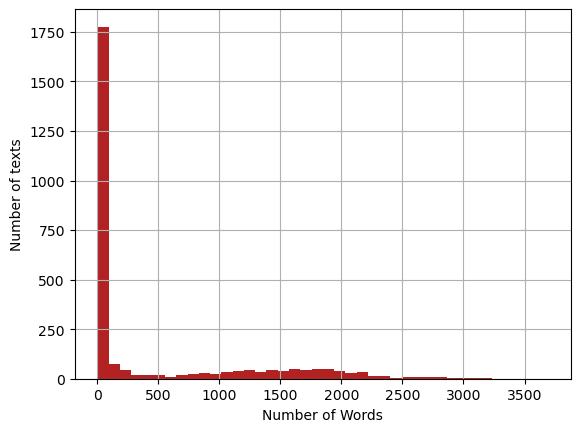

In [10]:
# Plot histogram of the number of words in train data 'title'
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [11]:
# Majority of titles above have word length under 15. So, we set max title length as 15
MAX_LENGTH = 200
# Tokenize and encode sequences in the train set
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)
# tokenize and encode sequences in the validation set
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

tokens_test_1 = tokenizer.batch_encode_plus(
    test_text_1.tolist(),
    max_length = MAX_LENGTH,
    pad_to_max_length=True,
    truncation=True
)

# tokenize and encode sequences in the test set
# tokens_test = tokenizer.batch_encode_plus(
#     test_text.tolist(),
#     max_length = MAX_LENGTH,
#     pad_to_max_length=True,
#     truncation=True
# )

/Users/jiangzongzhe/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2418: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [12]:
# Convert lists to tensors
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_1_seq = torch.tensor(tokens_test_1['input_ids']).to(device)
test_1_mask = torch.tensor(tokens_test_1['attention_mask']).to(device)
test_1_y = torch.tensor(test_labels_1).to(device)

# test_seq = torch.tensor(tokens_test['input_ids']).to(device)
# test_mask = torch.tensor(tokens_test['attention_mask']).to(device)
# test_y = torch.tensor(test_labels.tolist()).to(device)

In [13]:
# Data Loader structure definition
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 5                                               #define a batch size

train_data = TensorDataset(train_seq, train_mask, train_y)    # wrap tensors
train_sampler = RandomSampler(train_data)                     # sampler for sampling the data during training
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)
                                                              # dataLoader for train set
val_data = TensorDataset(val_seq, val_mask, val_y)            # wrap tensors
val_sampler = SequentialSampler(val_data)                     # sampler for sampling the data during training
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)
                                                              # dataLoader for validation set

test_1_data = TensorDataset(test_1_seq, test_1_mask, test_1_y)
test_1_sampler = SequentialSampler(test_1_data)
test_1_dataloader = DataLoader(test_1_data, sampler = test_1_sampler, batch_size=1)

In [14]:
# Freezing the parameters and defining trainable BERT structure
for param in bert.parameters():
    param.requires_grad = False    # false here means gradient need not be computed

In [18]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.15)           # dropout layer
      self.relu =  nn.ReLU()                    # relu activation function
      self.fc1 = nn.Linear(768,512)             # dense layer 1
      self.fc2 = nn.Linear(512,2)               # dense layer 2 (Output layer)
      self.softmax = nn.LogSoftmax(dim=1)       # softmax activation function
    def forward(self, sent_id, mask):           # define the forward pass
      cls_hs = self.bert(sent_id, attention_mask=mask).last_hidden_state[:, 0, :]
                                                # pass the inputs to the model
      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)                           # output layer
      x = self.softmax(x)                       # apply softmax activation
      return x

model = BERT_Arch(bert)
model = model.cpu()
# Defining the hyperparameters (optimizer, weights of the classes and the epochs)
# Define the optimizer
from torch.optim import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)          # learning rate
# Define the loss function
cross_entropy  = nn.NLLLoss()
# Number of training epochs
epochs = 10

In [25]:
epochs = 2

In [16]:
# Defining training and evaluation functions
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):                # iterate over batches
    if step % 50 == 0 and not step == 0:                        # progress update after every 50 batches.
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r.to(device) for r in batch]                       # push the batch to gpu
    sent_id, mask, labels = batch
    model.zero_grad()                                           # clear previously calculated gradients
    preds = model(sent_id, mask)                                # get model predictions for current batch
    loss = cross_entropy(preds, labels.long())                  # compute loss between actual & predicted values
    total_loss = total_loss + loss.item()                       # add on to the total loss
    loss.backward()                                             # backward pass to calculate the gradients
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)     # clip gradients to 1.0. It helps in preventing exploding gradient problem
    optimizer.step()                                            # update parameters
    preds=preds.detach().cpu().numpy()                          # model predictions are stored on GPU. So, push it to CPU

  avg_loss = total_loss / len(train_dataloader)                 # compute training loss of the epoch
                                                                # reshape predictions in form of (# samples, # classes)
  return avg_loss                                 # returns the loss and predictions

def evaluate():
  print("\nEvaluating...")
  model.eval()                                    # Deactivate dropout layers
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):    # Iterate over batches
    if step % 50 == 0 and not step == 0:          # Progress update every 50 batches.
                                                  # Calculate elapsed time in minutes.
                                                  # Elapsed = format_time(time.time() - t0)
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))
                                                  # Report progress
    batch = [t.to(device) for t in batch]         # Push the batch to GPU
    sent_id, mask, labels = batch
    with torch.no_grad():                         # Deactivate autograd
      preds = model(sent_id, mask)                # Model predictions
      loss = cross_entropy(preds,labels.long())   # Compute the validation loss between actual and predicted values
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)     # compute the validation loss of the epoch
  return avg_loss

In [26]:
# Train and predict (OPTIONAL)
best_valid_loss = float('inf')
train_losses=[]                                   # empty lists to store training and validation loss of each epoch
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()                          # train model
    valid_loss = evaluate()                       # evaluate model
    if valid_loss < best_valid_loss:              # save the best model
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'new_model_weights.pt')
    train_losses.append(train_loss)               # append training and validation loss
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    529.
  Batch   100  of    529.
  Batch   150  of    529.
  Batch   200  of    529.
  Batch   250  of    529.
  Batch   300  of    529.
  Batch   350  of    529.
  Batch   400  of    529.
  Batch   450  of    529.
  Batch   500  of    529.

Evaluating...
  Batch    50  of    133.
  Batch   100  of    133.

Training Loss: 0.611
Validation Loss: 0.599

 Epoch 2 / 2
  Batch    50  of    529.
  Batch   100  of    529.
  Batch   150  of    529.
  Batch   200  of    529.
  Batch   250  of    529.
  Batch   300  of    529.
  Batch   350  of    529.
  Batch   400  of    529.
  Batch   450  of    529.
  Batch   500  of    529.

Evaluating...
  Batch    50  of    133.
  Batch   100  of    133.

Training Loss: 0.611
Validation Loss: 0.601


In [30]:
# save weights of trained model (OPTIONAL)
path = 'fakenews_weights.pt'
torch.save(model.state_dict(), path)

In [28]:
with torch.no_grad():
  preds = model(test_1_seq, test_1_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_1_y.cpu(), preds))

              precision    recall  f1-score   support

           0       0.74      0.53      0.62       461
           1       0.72      0.86      0.79       641

    accuracy                           0.73      1102
   macro avg       0.73      0.70      0.70      1102
weighted avg       0.73      0.73      0.72      1102



In [31]:
path = 'fakenews_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
torch.cuda.empty_cache()
import gc
gc.collect()
torch.cuda.memory_summary(device=None, abbreviated=False)

'|===========================================================================|\n|                  PyTorch CUDA memory summary, device ID 0                 |\n|---------------------------------------------------------------------------|\n|            CUDA OOMs: 3            |        cudaMalloc retries: 4         |\n|===========================================================================|\n|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |\n|---------------------------------------------------------------------------|\n| Allocated memory      |   4972 MiB |  14641 MiB |   4515 GiB |   4511 GiB |\n|       from large pool |   4971 MiB |  14639 MiB |   4314 GiB |   4309 GiB |\n|       from small pool |      0 MiB |      1 MiB |    201 GiB |    201 GiB |\n|---------------------------------------------------------------------------|\n| Active memory         |   4972 MiB |  14641 MiB |   4515 GiB |   4511 GiB |\n|       from large pool |   4971 MiB |  14639 MiB |

In [ ]:
import os

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "0:2048"

import torch
torch.cuda.empty_cache()
torch.cuda.get_device_name(0)

RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx